In [1]:
import os
import random
import importlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import myutils
import my_models
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import image_dataset_from_directory, img_to_array
from keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image, ImageOps
from IPython.display import display

importlib.reload(myutils)  # reload the module so changes are applied 
importlib.reload(my_models)  # reload the module so changes are applied 

<module 'my_models' from '/Users/wesleychou/Documents/GitHub/crack-detection/my_models.py'>

In [2]:
SIZE = (28, 28)    # image size
INPUT_SHAPE = (SIZE[0], SIZE[1], 1)  # input shape for CNNs
LR = 0.001    # learning rate
EPC = 10    # epochs

Original dataset consists of two folders, each with 15,000 images. It is obtained from https://www.kaggle.com/datasets/oluwaseunad/concrete-and-pavement-crack-images/code.

I used the `ulimit -n` and `ls | shuf -n 1000 | xargs -I {} cp "{}" ~target/` command to randomly pick 1000 images from each folder. 

They are stored in the `negative` and `positive` folders, under `sample-data`. Negative images have no cracks. Positive images have cracks.
Let's take a look at the images.

In [3]:
# # load the images
# ds_images = tf.keras.utils.image_dataset_from_directory(
#     directory='sample-data/',
#     labels='inferred',
#     class_names=['negative', 'positive'],
# )

# # display the first 16 images
# for images, labels in ds_images.take(1):
#     fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
#     for i, ax in enumerate(axes.flat):
#         ax.imshow(images[i].numpy().astype("uint8"))
#         ax.axis("off")
#         ax.set_title(ds_images.class_names[int(labels[i])])


Now we grayscale and resize the images. We will also shuffle it.

In [4]:
# ds_images = image_dataset_from_directory(
#     directory='sample-data/',
#     labels='inferred',
#     class_names=['negative', 'positive'],
#     color_mode='grayscale',  # grayscale
#     image_size=SIZE,  # resize
#     shuffle=True,  # shuffle
#     seed=42,
# )

# # display the first 16 images
# for images, labels in ds_images.take(1):
#     fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
#     for i, ax in enumerate(axes.flat):
#         ax.imshow(images[i].numpy().astype("uint8"))
#         ax.axis("off")
#         ax.set_title(ds_images.class_names[int(labels[i])])

In [5]:
# load images as PIL images, grayscaled and resized
images = myutils.load_images('sample-data/negative', SIZE) + myutils.load_images('sample-data/positive', SIZE)

X = np.zeros((2000, SIZE[0], SIZE[1], 1))
y = np.zeros((2000,))

# change PIL images to numpy arrays
for i, img in enumerate(images):
    X[i] = img_to_array(img)
    y[i] = (0 if i < 1000 else 1)

# normalize image data
X = X.astype('float32') / 255
y = y.astype('float32') / 255

# shuffle in unison
X, y = shuffle(X, y, random_state=42)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (2000, 28, 28, 1)
y shape: (2000,)


Now we split the data into training, cross-validation, and testing sets using a 60-20-20 ratio.

In [6]:
# split data into train, cross-validation, and test
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
print("Dataset shapes: \n")
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X cv:", X_cv.shape)
print("y cv:", y_cv.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)

Dataset shapes: 

X train: (1200, 28, 28, 1)
y train: (1200,)
X cv: (400, 28, 28, 1)
y cv: (400,)
X test: (400, 28, 28, 1)
y test: (400,)


Let's take a look at the images in our training set.

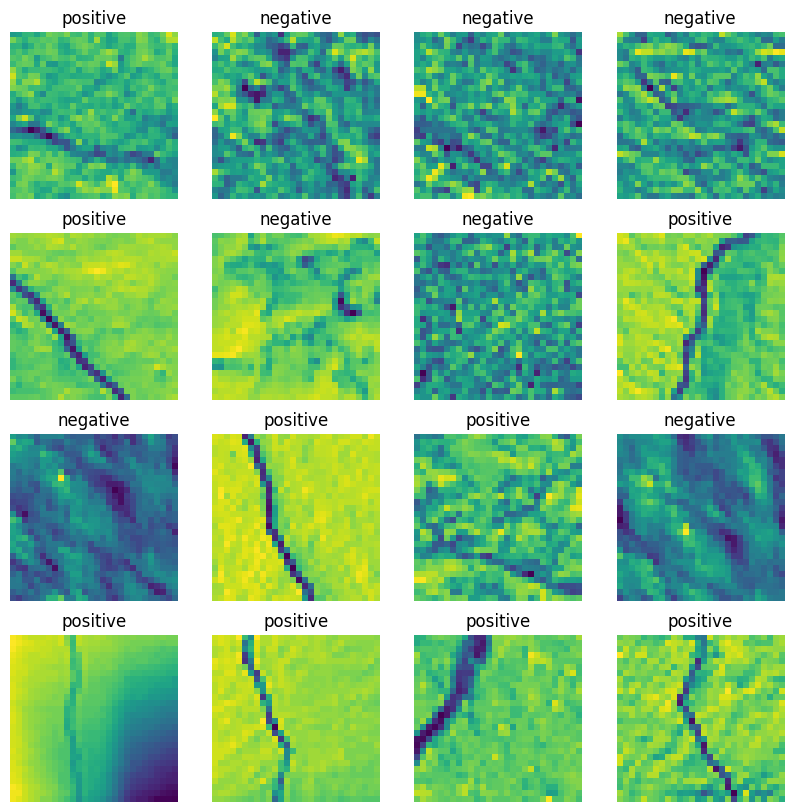

In [7]:
# display the first 16 images in training set
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(SIZE))
    ax.axis("off")
    ax.set_title("positive" if y_train[i]>0 else "negative")

Split training data 60-20-20 (train, cv, test)

In [ ]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
print("Dataset shapes: \n")
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X cv:", X_cv.shape)
print("y cv:", y_cv.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)

Dataset shapes: 

X train: (1200, 28, 28)
y train: (1200,)
X cv: (400, 28, 28)
y cv: (400,)
X test: (400, 28, 28)
y test: (400,)


In [ ]:
# create model
tf.random.set_seed(42)
input_shape = (SIZE[0], SIZE[1], 1)

model = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
        
    ], name = "model1"
)

In [ ]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, epochs=EPC, 
                    validation_data=(X_cv, y_cv))

Epoch 1/10
38/38 [==============================] - 1s 16ms/step - loss: 0.6826 - accuracy: 0.5817 - val_loss: 0.6362 - val_accuracy: 0.7550
Epoch 2/10
38/38 [==============================] - 0s 11ms/step - loss: 0.5479 - accuracy: 0.7492 - val_loss: 0.5287 - val_accuracy: 0.7275
Epoch 3/10
38/38 [==============================] - 0s 12ms/step - loss: 0.4538 - accuracy: 0.8125 - val_loss: 0.4097 - val_accuracy: 0.8150
Epoch 4/10
38/38 [==============================] - 0s 13ms/step - loss: 0.4207 - accuracy: 0.8142 - val_loss: 0.4195 - val_accuracy: 0.7950
Epoch 5/10
38/38 [==============================] - 0s 11ms/step - loss: 0.4232 - accuracy: 0.8183 - val_loss: 0.3757 - val_accuracy: 0.8575
Epoch 6/10
38/38 [==============================] - 0s 11ms/step - loss: 0.3938 - accuracy: 0.8258 - val_loss: 0.3453 - val_accuracy: 0.8625
Epoch 7/10
38/38 [==============================] - 0s 12ms/step - loss: 0.3835 - accuracy: 0.8275 - val_loss: 0.3359 - val_accuracy: 0.8500
Epoch 8/10
38

Evaluate model

Evaluation with cross-validation dataset:

loss = 0.33096539974212646
accuracy = 0.8525000214576721


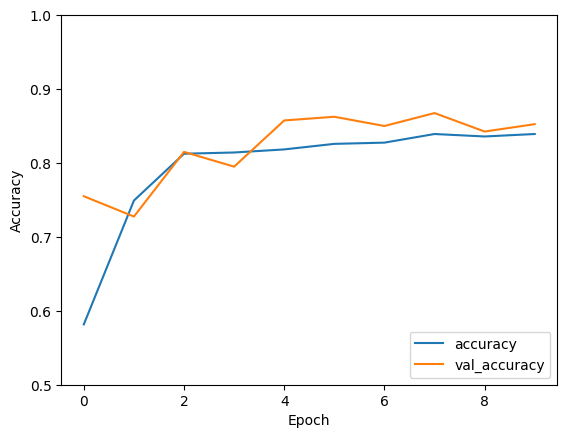

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print("Evaluation with cross-validation dataset:\n")
cv_loss, cv_acc = model.evaluate(X_cv, y_cv, verbose=0)
print(f"loss = {cv_loss}\naccuracy = {cv_acc}")

Hyperparameter Tuning

Lets try out different learning rates.

Cross validation metrics:

Learning rate = 0.1
	loss = 0.6930612325668335
	accuracy = 0.5274999737739563
Learning rate = 0.01
	loss = 0.2981254458427429
	accuracy = 0.8799999952316284
Learning rate = 0.001
	loss = 0.33096539974212646
	accuracy = 0.8525000214576721
Learning rate = 0.0001
	loss = 0.4723745286464691
	accuracy = 0.7925000190734863


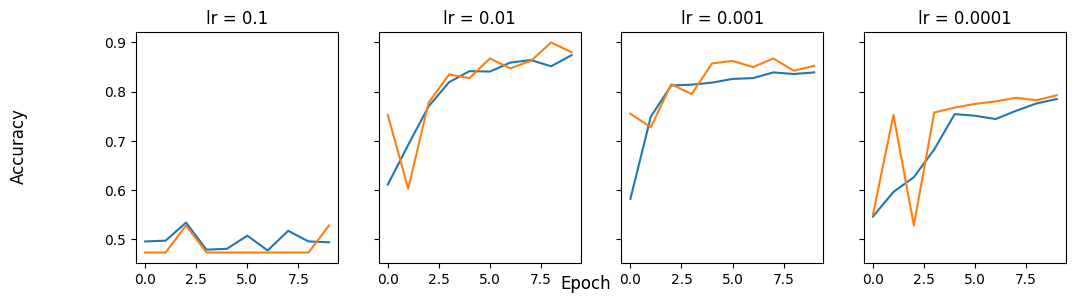

In [ ]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]  # different learning rate values

fig, axes = plt.subplots(ncols=len(learning_rates), figsize=(12,3), sharey=True)
fig.supylabel('Accuracy')
fig.supxlabel('Epoch')

print("Cross validation metrics:\n")

for i, lr in enumerate(learning_rates):
    # reset the model
    model = myutils.create_model(INPUT_SHAPE)
    
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    history = model.fit(X_train, y_train, epochs=EPC, 
                        validation_data=(X_cv, y_cv), verbose=0)
    
    axes[i].set_title(f"lr = {lr}")
    axes[i].plot(history.history['accuracy'], label='accuracy')
    axes[i].plot(history.history['val_accuracy'], label = 'val_accuracy')

    cv_loss, cv_acc = model.evaluate(X_cv, y_cv, verbose=0)
    print("Learning rate =", lr)
    print(f"\tloss = {cv_loss}\n\taccuracy = {cv_acc}")
    

From here we can see that a learning rate of 0.01 is preferred.

In [ ]:
LR = 0.01

For `LR = 0.01`, we can see that the model performs better in terms of accuracy. However, we also see that the curves oscillate heavily. This is a sign of overfitting. We will try out different models and regularization techniques to address this.

In [ ]:
mymodels = my_models.MyModels()

# this is the original model, call it model 1
model_1 = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_1", model_1)

# model 2
model_2 = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_2", model_2)

# TODO: I NEED TO CHOOSE A MODEL BEFORE TUNING. GOTTA MOVE THIS ENTIRE THING UP

mymodels.print_models()

['model_1', 'model_2']


In [ ]:

------------------------------------------------------------------------------

SyntaxError: invalid syntax (626090593.py, line 1)

Ways to improve model:

**MUST DO!**
1. filter images to make crack more obvious    <------ THIS!!!
2. try diff models
    - add/remove layers, increase/decrease neurons
    - regularization like L1 or L2
    - dropout layers
3. tuning hyperparameters like learning rate

Let's try increasing the number of epochs.

Epoch 1/50
38/38 [==============================] - 1s 16ms/step - loss: 0.6872 - accuracy: 0.5433 - val_loss: 0.6594 - val_accuracy: 0.8200
Epoch 2/50
38/38 [==============================] - 0s 11ms/step - loss: 0.5778 - accuracy: 0.7492 - val_loss: 0.4874 - val_accuracy: 0.7700
Epoch 3/50
38/38 [==============================] - 0s 11ms/step - loss: 0.4853 - accuracy: 0.7883 - val_loss: 0.4193 - val_accuracy: 0.8275
Epoch 4/50
38/38 [==============================] - 0s 13ms/step - loss: 0.4418 - accuracy: 0.8125 - val_loss: 0.3968 - val_accuracy: 0.8625
Epoch 5/50
38/38 [==============================] - 0s 11ms/step - loss: 0.4270 - accuracy: 0.8233 - val_loss: 0.3710 - val_accuracy: 0.8375
Epoch 6/50
38/38 [==============================] - 0s 11ms/step - loss: 0.4170 - accuracy: 0.8250 - val_loss: 0.3807 - val_accuracy: 0.8700
Epoch 7/50
38/38 [==============================] - 0s 12ms/step - loss: 0.3929 - accuracy: 0.8383 - val_loss: 0.3597 - val_accuracy: 0.8375
Epoch 8/50
38

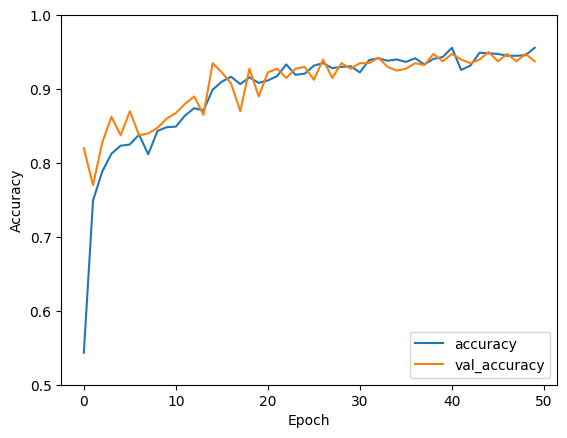

In [ ]:
EPC = 50    # used to be 10

# reset model
model = myutils.create_model(INPUT_SHAPE)

model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
        metrics=['accuracy']
    )
history = model.fit(X_train, y_train, epochs=EPC, validation_data=(X_cv, y_cv))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We can see that both `accuracy` and `val_accuracy` oscillates up and down. This indicates an overfitting of data. We will try regularization techniques